In [7]:

import itertools
import math
from collections import OrderedDict, Counter
from dataclasses import dataclass
from typing import Dict, Optional, Sequence, Tuple, List
from typing import Iterable

import matplotlib.pyplot as plt
import networkx as nx
import torch
from pytorch_lightning import seed_everything
from rdkit import Chem
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from src.datasets.zinc_pairs import pyg_to_nx
from src.datasets.zinc_smiles_generation import ZincSmiles
from src.encoding.configs_and_constants import DatasetConfig, Features, FeatureConfig, IndexRange
from src.encoding.feature_encoders import CombinatoricIntegerEncoder
from src.encoding.graph_encoders import HyperNet, load_or_create_hypernet
from src.encoding.the_types import VSAModel
from src.utils.utils import GLOBAL_MODEL_PATH

"""
Features
    Atom types size: 9
    Atom types: ['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']
    Degrees size: 5, encoded with 0 index:
    Degrees: {1, 2, 3, 4, 5}
    Formal Charges size: 3
    Formal Charges: {0, 1, -1}
    Explicit Hs size: 4
    Explicit Hs: {0, 1, 2, 3}
Encodings:
    float(ZINC_SMILE_ATOM_TO_IDX[atom.GetSymbol()]),
    float(atom.GetDegree() - 1),  # [1, 2, 3, 4, 5] -> [0, 1, 2, 3, 4]
    float(atom.GetFormalCharge() if atom.GetFormalCharge() >= 0 else 2),  # [0, 1, -1] -> [0, 1, 2]
    float(atom.GetTotalNumHs()),
"""

"\nFeatures\n    Atom types size: 9\n    Atom types: ['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']\n    Degrees size: 5, encoded with 0 index:\n    Degrees: {1, 2, 3, 4, 5}\n    Formal Charges size: 3\n    Formal Charges: {0, 1, -1}\n    Explicit Hs size: 4\n    Explicit Hs: {0, 1, 2, 3}\nEncodings:\n    float(ZINC_SMILE_ATOM_TO_IDX[atom.GetSymbol()]),\n    float(atom.GetDegree() - 1),  # [1, 2, 3, 4, 5] -> [0, 1, 2, 3, 4]\n    float(atom.GetFormalCharge() if atom.GetFormalCharge() >= 0 else 2),  # [0, 1, -1] -> [0, 1, 2]\n    float(atom.GetTotalNumHs()),\n"

In [13]:
seed = 42

seed_everything(seed)
device = torch.device('cpu')
# ----- hypernet config (kept for provenance; not needed in this flow) -----
ds_name = "ZincSmilesHRR7744"
zinc_feature_bins = [9, 6, 3, 4]
dataset_config = DatasetConfig(
    seed=42,
    name=ds_name,
    vsa=VSAModel.HRR,
    hv_dim=88 * 88,
    device=device,
    node_feature_configs=OrderedDict(
        [
            (

                Features.ATOM_TYPE,
                FeatureConfig(
                    count=math.prod(zinc_feature_bins),
                    encoder_cls=CombinatoricIntegerEncoder,
                    index_range=IndexRange((0, 4)),
                    bins=zinc_feature_bins,
                ),
            ),
        ]
    ),
)

print("Loading/creating hypernet …")
hypernet: HyperNet = (
    load_or_create_hypernet(path=GLOBAL_MODEL_PATH, cfg=dataset_config).to(device=device)
)
print("Hypernet ready.")
assert not hypernet.use_edge_features()
assert not hypernet.use_graph_features()

batch_size = 2
zinc_smiles = ZincSmiles(split="train")
dataloader = DataLoader(dataset=zinc_smiles, batch_size=batch_size, shuffle=False)
batch = next(iter(dataloader))

# Encode the whole graph in one HV
encoded_data = hypernet.forward(batch)
node_term = encoded_data["node_terms"]
graph_term = encoded_data["graph_embedding"]

Seed set to 42


Loading/creating hypernet …
Loading existing HyperNet from /Users/arvandkaveh/Projects/kit/graph_hdc/_models/hypernet_ZincSmilesHRR7744_HRR_dim7744_s42_depth3_ecb0.pt
Hypernet ready.


In [14]:
nodes_decoded_counter = hypernet.decode_order_zero_counter(node_term)

In [15]:


# ---------------------------
# Feature representation
# ---------------------------

ATOM_TYPES = ['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']  # index -> symbol
FORMAL_CHARGE_IDX_TO_VAL: Dict[int, str] = {0: "0", 1: "+", 2: "-"}


def feature_label_text(G: nx.Graph, n: int,
                       atom_symbols: Sequence[str] = ATOM_TYPES,
                       show_current_degree: bool = False,
                       show_residual: bool = False) -> str:
    """
    Build a compact, readable label string for a node.

    The label always reflects **frozen** features from ``node['feat']``.
    Optionally, include the *current* degree and residual for debugging.

    :param G: Graph with node attributes ``feat: Feat`` and ``target_degree``.
    :param n: Node id.
    :param atom_symbols: Mapping from atom index to chemical symbol.
    :param show_current_degree: If ``True``, append current degree.
    :param show_residual: If ``True``, append residual stubs.
    :returns: Label string like ``C | deg*:3 | H:1 | q:0 (cur:2,res:1)``.
    """
    f = G.nodes[n]["feat"]
    at_idx, deg_idx, ch_idx, hs = f.to_tuple()

    atom = atom_symbols[at_idx] if 0 <= at_idx < len(atom_symbols) else f"X{at_idx}"
    deg_star = getattr(f, "target_degree", None) or (deg_idx + 1)
    charge = FORMAL_CHARGE_IDX_TO_VAL.get(ch_idx, ch_idx)

    parts = [f"{atom}", f"deg*:{deg_star}", f"H:{hs}", f"q:{charge}"]
    base = " | ".join(parts)

    if show_current_degree or show_residual:
        cur = G.degree[n]
        res = int(G.nodes[n]["target_degree"]) - cur
        extra = []
        if show_current_degree:
            extra.append(f"cur:{cur}")
        if show_residual:
            extra.append(f"res:{res}")
        if extra:
            base = f"{base} ({','.join(extra)})"

    return base


def compute_layout(G: nx.Graph, layout: str = "spring", seed: int = 42) -> Dict[int, Tuple[float, float]]:
    """
    Compute deterministic 2D positions for drawing.

    :param G: Graph.
    :param layout: One of ``'spring'``, ``'kamada_kawai'``, ``'circular'``, ``'shell'``.
    :param seed: Seed for deterministic layouts.
    :returns: Mapping ``node -> (x, y)``.
    """
    layout = layout.lower()
    if layout == "spring":
        return nx.spring_layout(G, seed=seed, k=None)
    if layout == "kamada_kawai":
        return nx.kamada_kawai_layout(G)
    if layout == "circular":
        return nx.circular_layout(G)
    if layout == "shell":
        return nx.shell_layout(G)
    raise ValueError(f"Unknown layout: {layout}")



def draw_with_atom_coloring(G: nx.Graph,
                            *,
                            atom_symbols: Sequence[str] = ATOM_TYPES,
                            layout: str = "spring",
                            seed: int = 42,
                            node_size: int = 500,
                            font_size: int = 9,
                            show_current_degree: bool = False,
                            show_residual: bool = False,
                            ax: Optional[plt.Axes] = None) -> plt.Axes:
    """
    Variant with simple categorical coloring by atom type index.

    :param atom_symbols:
    :param G: Graph with node attribute ``feat: Feat``.
    :returns: Axes.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 5))

    pos = compute_layout(G, layout=layout, seed=seed)

    # Map atom_type -> color using a minimal palette (cycled).
    palette = ["#7f7f7f", "#1f77b4", "#2ca02c", "#d62728", "#9467bd",
               "#8c564b", "#e377c2", "#bcbd22", "#17becf", "#ff7f0e"]
    colors: List[str] = []
    for n in G.nodes:
        at_idx = G.nodes[n]["feat"].atom_type
        colors.append(palette[at_idx % len(palette)])

    nx.draw_networkx_edges(G, pos, ax=ax, width=1.5)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors, edgecolors="#333333",
                           linewidths=1.0, node_size=node_size)

    labels = {
        n: feature_label_text(G, n,
                              atom_symbols=atom_symbols,
                              show_current_degree=show_current_degree,
                              show_residual=show_residual)
        for n in G.nodes
    }
    nx.draw_networkx_labels(G, pos, labels=labels, ax=ax, font_size=font_size)

    ax.axis("off")
    ax.set_title("Graph (colored by atom type, frozen features)", fontsize=11)
    return ax


# Feature representation
# ---------------------------

@dataclass(frozen=True)
class Feat:
    """
    Hashable node feature (discrete indices).

    :param atom_type: Index of atom type (e.g., Br,C,Cl,F,I,N,O,P,S mapped to ints).
    :param degree_idx: Degree minus one, i.e. 0->deg 1, 4->deg 5.
    :param formal_charge_idx: Encoded as 0,1,2 for charges [0,1,-1] respectively.
    :param explicit_hs: Total explicit hydrogens (0..3).
    """
    atom_type: int
    degree_idx: int
    formal_charge_idx: int
    explicit_hs: int

    @property
    def target_degree(self) -> int:
        """Final/desired node degree (degree index + 1)."""
        return self.degree_idx + 1

    def to_tuple(self) -> tuple[int, int, int, int]:
        """Return (atom_type, degree_idx, formal_charge_idx, explicit_hs)."""
        return self.atom_type, self.degree_idx, self.formal_charge_idx, self.explicit_hs

    @staticmethod
    def from_tuple(t: tuple[int, int, int, int]) -> "Feat":
        """Construct from a 4-tuple."""
        a, d, c, h = t
        return Feat(int(a), int(d), int(c), int(h))


# ---------------------------
# Canonical hashing / dedup
# ---------------------------

def canonical_wl_hash(G: nx.Graph, *, iterations: int = 3) -> str:
    """
    Weisfeiler–Lehman graph hash that respects node features.

    The node label used for hashing is derived from ``node['feat'].to_tuple()``.

    :param G: Graph with node attribute ``feat: Feat``.
    :param iterations: WL refinement iterations (>=1).
    :returns: Deterministic hash string invariant to isomorphism.
    """
    H = G.copy()
    for n in H.nodes:
        f = H.nodes[n]["feat"]
        H.nodes[n]["__wl_label__"] = ",".join(map(str, f.to_tuple()))
    return nx.weisfeiler_lehman_graph_hash(H, node_attr="__wl_label__", iterations=iterations)


def dedup_key(G: nx.Graph) -> Tuple[str, int, int]:
    """
    Compact key for candidate deduplication.

    :returns: (wl_hash, |V|, |E|) tuple suitable for a set/dict key.
    """
    return canonical_wl_hash(G), G.number_of_nodes(), G.number_of_edges()


# ---------------------------
# Counters / totals
# ---------------------------




# ---------------------------
# Feature multiset utilities
# ---------------------------

def feature_counter_from_graph(G: nx.Graph) -> Counter[Tuple[int, int, int, int]]:
    """
    Count node features in a graph.

    :returns: Counter keyed by ``feat.to_tuple()``.
    """
    c = Counter()
    for n in G.nodes:
        c[G.nodes[n]["feat"].to_tuple()] += 1
    return c


def leftover_features(full: Counter[Tuple[int, int, int, int]], G: nx.Graph) -> Counter:
    """
    Remaining features to be placed given the current graph.

    :param full: Full target multiset of node features.
    :param G: Current partial graph.
    :returns: Non-negative counter of leftover feature tuples.
    """
    left = full.copy()
    left.subtract(feature_counter_from_graph(G))
    # drop non-positive
    for k in list(left):
        if left[k] <= 0:
            del left[k]
    return left


# ---------------------------
# Graph construction/manipulation
# ---------------------------


def add_node_with_feat(G: nx.Graph, feat: Feat, node_id: Optional[int] = None) -> int:
    """
    Add a node with frozen features.

    :param G: Target graph (modified in place).
    :param feat: Frozen node features.
    :param node_id: Optional explicit node id. If ``None``, uses ``max_id+1`` or ``0``.
    :returns: The node id used.
    """
    if node_id is None:
        node_id = 0 if not G.nodes else (max(G.nodes) + 1)
    G.add_node(node_id, feat=feat, target_degree=feat.target_degree)
    return node_id


def current_degree(G: nx.Graph, node: int) -> int:
    """
    Current degree of ``node`` (undirected).

    :param G: Graph.
    :param node: Node id.
    :returns: Degree in the *current* partial graph.
    """
    return G.degree[node]


def residual_degree(G: nx.Graph, node: int) -> int:
    """
    Residual degree capacity = ``target_degree - current_degree``.

    :param G: Graph.
    :param node: Node id.
    :returns: Remaining stubs (>= 0).
    """
    return int(G.nodes[node]["target_degree"]) - current_degree(G, node)


def residuals(G: nx.Graph) -> Dict[int, int]:
    """
    Residual degrees for all nodes.

    :param G: Graph.
    :returns: Mapping ``node -> residual_degree``.
    """
    return {n: residual_degree(G, n) for n in G.nodes}


def anchors(G: nx.Graph) -> List[int]:
    """
    Nodes that can still accept edges (residual > 0).

    :param G: Graph.
    :returns: List of node ids.
    """
    return [n for n in G.nodes if residual_degree(G, n) > 0]


def add_edge_if_possible(G: nx.Graph, u: int, v: int, *, strict: bool = True) -> bool:
    """
    Add an undirected edge if constraints allow it.

    Constraints:
    - ``u != v``
    - Edge must not already exist.
    - Both endpoints must have residual > 0.
    - If ``strict``: never exceed target degrees.

    :param G: Graph (modified in place).
    :param u: Endpoint node.
    :param v: Endpoint node.
    :param strict: Enforce residual checks.
    :returns: ``True`` if edge was added, else ``False``.
    """
    if u == v or G.has_edge(u, v):
        return False
    if strict and (residual_degree(G, u) <= 0 or residual_degree(G, v) <= 0):
        return False
    G.add_edge(u, v)
    if strict and (residual_degree(G, u) < 0 or residual_degree(G, v) < 0):
        # rollback if we over-shot due to concurrent edits
        G.remove_edge(u, v)
        return False
    return True


# ---------------------------
# Conversions: NetworkX -> PyG
# ---------------------------

def nx_to_pyg(G: nx.Graph) -> "Data":
    """
    Convert an undirected NetworkX graph with ``feat`` attributes to a
    :class:`torch_geometric.data.Data`.

    Node features are stacked as a dense matrix ``x`` of dtype ``long`` with
    columns ``[atom_type, degree_idx, formal_charge_idx, explicit_hs]``.

    Undirected edges are converted to a directed ``edge_index`` with both
    directions.

    :param G: NetworkX graph where each node has a ``feat: Feat`` attribute.
    :returns: PyG ``Data`` object with fields ``x`` and ``edge_index``.
    :raises RuntimeError: If PyTorch/PyG are not available.
    """
    if torch is None or Data is None:
        raise RuntimeError("torch / torch_geometric are required for nx_to_pyg")

    # Node ordering: use sorted ids for determinism
    nodes = sorted(G.nodes)
    idx_of: Dict[int, int] = {n: i for i, n in enumerate(nodes)}

    # Features
    feats: List[List[int]] = [list(G.nodes[n]["feat"].to_tuple()) for n in nodes]
    x = torch.tensor(feats, dtype=torch.long)

    # Edges: add both directions
    src, dst = [], []
    for u, v in G.edges():
        iu, iv = idx_of[u], idx_of[v]
        src.extend([iu, iv])
        dst.extend([iv, iu])
    if src:
        edge_index = torch.tensor([src, dst], dtype=torch.long)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)

    return Data(x=x, edge_index=edge_index)

def pyg_to_nx(
    data: "Data",
    *,
    strict_undirected: bool = True,
    allow_self_loops: bool = False,
) -> nx.Graph:
    """
    Convert a PyG ``Data`` (undirected, bidirectional edges) to a mutable NetworkX graph.

    Assumptions
    ----------
    - ``data.x`` has shape ``[N, 4]`` with integer-encoded features:
      ``[atom_type, degree_idx, formal_charge_idx, explicit_hs]``.
    - ``data.edge_index`` is bidirectional (both (u,v) and (v,u) present) for undirected graphs.
    - Features are **frozen** and represent the final target degrees.

    Node attributes
    ---------------
    - ``feat``: ``Feat`` instance (constructed from the 4-tuple).
    - ``target_degree``: ``feat.target_degree`` (== ``degree_idx + 1``).

    Parameters
    ----------
    data : Data
        PyG data object.
    strict_undirected : bool, optional
        If ``True``, assert that ``edge_index`` is symmetric.
    allow_self_loops : bool, optional
        If ``False``, drop self-loops.

    Returns
    -------
    nx.Graph
        Mutable undirected graph with node attributes.

    Raises
    ------
    ValueError
        If feature dimensionality is not ``[N, 4]`` or edges are not symmetric when required.
    """
    if data.x is None:
        raise ValueError("data.x is None (expected [N,4] features).")
    if data.edge_index is None:
        raise ValueError("data.edge_index is None.")

    x = data.x
    if x.dim() != 2 or x.size(1) != 4:
        raise ValueError(f"Expected data.x shape [N,4], got {tuple(x.size())}.")

    # Ensure integer features
    if not torch.is_floating_point(x):
        x_int = x.to(torch.long)
    else:
        x_int = x.to(torch.long)  # safe cast, your encoding is discrete

    N = x_int.size(0)
    ei = data.edge_index
    if ei.dim() != 2 or ei.size(0) != 2:
        raise ValueError("edge_index must be [2, E].")
    src = ei[0].to(torch.long)
    dst = ei[1].to(torch.long)

    # Build undirected edge set (dedup, optional self-loop handling)
    pairs = set()
    for u, v in zip(src.tolist(), dst.tolist()):
        if u == v and not allow_self_loops:
            continue
        a, b = (u, v) if u < v else (v, u)
        pairs.add((a, b))

    if strict_undirected:
        # Check that for every (u,v) there is a (v,u) in the original directed list
        dir_pairs = set(zip(src.tolist(), dst.tolist()))
        for (u, v) in list(pairs):
            if (u, v) not in dir_pairs or (v, u) not in dir_pairs:
                raise ValueError(f"edge_index is not symmetric for undirected edge ({u},{v}).")

    # Construct NX graph
    G = nx.Graph()
    G.add_nodes_from(range(N))

    # Attach features and target degrees
    for n in range(N):
        t = tuple(int(z) for z in x_int[n].tolist())  # (atom_type, degree_idx, formal_charge_idx, explicit_hs)
        f = Feat.from_tuple(t)                        # requires your Feat dataclass
        G.nodes[n]["feat"] = f
        G.nodes[n]["target_degree"] = f.target_degree

    # Add edges
    G.add_edges_from(pairs)
    return G


def pyg_batch_to_nx_list(
    data: "Data",
    *,
    strict_undirected: bool = True,
    allow_self_loops: bool = False,
) -> List[nx.Graph]:
    """
    Split a batched PyG ``Data`` (with ``data.batch``) into a list of NX graphs.

    Parameters
    ----------
    data : Data
        Batched data where ``data.batch`` maps each node to its graph id.
    strict_undirected : bool, optional
        Enforce symmetric ``edge_index`` per graph.
    allow_self_loops : bool, optional
        Keep or drop self-loops.

    Returns
    -------
    list of nx.Graph
        One NetworkX graph per batch component, node-labeled ``0..n_i-1`` in each.
    """
    if getattr(data, "batch", None) is None:
        # Treat as a single graph
        return [pyg_to_nx(data, strict_undirected=strict_undirected, allow_self_loops=allow_self_loops)]

    batch = data.batch.to(torch.long)
    num_g = int(batch.max().item()) + 1 if batch.numel() else 0
    out: List[nx.Graph] = []

    # Pre-slice nodes for each component
    node_indices_per_g: List[torch.Tensor] = [
        (batch == gi).nonzero(as_tuple=False).view(-1) for gi in range(num_g)
    ]

    # Edge routing: assign an edge to component i iff both endpoints are in that component
    src = data.edge_index[0].to(torch.long)
    dst = data.edge_index[1].to(torch.long)
    for gi, nidx in enumerate(node_indices_per_g):
        if nidx.numel() == 0:
            out.append(nx.Graph())
            continue

        # Map global -> local
        glob2loc = {int(g): i for i, g in enumerate(nidx.tolist())}

        # Select edges internal to this component
        mask = (batch[src] == gi) & (batch[dst] == gi)
        src_i = src[mask].tolist()
        dst_i = dst[mask].tolist()

        # Build a temporary Data slice (no deep copies of tensors beyond what's needed)
        x_i = data.x[nidx]
        if x_i.dim() != 2 or x_i.size(1) != 4:
            raise ValueError(f"[batch {gi}] Expected x shape [n,4], got {tuple(x_i.size())}.")

        # Remap edges to local node ids
        edges_local: List[Tuple[int, int]] = []
        for u, v in zip(src_i, dst_i):
            uL = glob2loc[int(u)]
            vL = glob2loc[int(v)]
            edges_local.append((uL, vL))

        # Assemble a minimal Data for reuse
        di = Data(
            x=x_i,
            edge_index=torch.tensor(edges_local, dtype=torch.long).t().contiguous() if edges_local else torch.empty((2,0), dtype=torch.long)
        )
        out.append(pyg_to_nx(di, strict_undirected=strict_undirected, allow_self_loops=allow_self_loops))

    return out

# ---------------------------
# Small helpers for search/decoding
# ---------------------------


def add_node_and_connect(G: nx.Graph, feat: Feat, connect_to: Sequence[int]) -> Optional[int]:
    """
    Add a node and try to connect it to a set of anchors (greedy, respects residuals).

    :param G: Graph (modified in place).
    :param feat: Features of the new node.
    :param connect_to: Candidate anchor nodes to attempt connections.
    :returns: New node id, or ``None`` if no valid placement (edge constraints violated).
    """
    nid = add_node_with_feat(G, feat)
    ok = True
    for a in connect_to:
        if residual_degree(G, nid) <= 0:
            break
        if residual_degree(G, a) <= 0:
            continue
        if not add_edge_if_possible(G, nid, a, strict=True):
            ok = False
            break
    if not ok:
        G.remove_node(nid)
        return None
    return nid


# ---------------------------
# Exact induced-subgraph oracle (deterministic)
# ---------------------------
def is_induced_subgraph_feature_aware(G_small: nx.Graph, G_big: nx.Graph) -> bool:
    """NetworkX VF2: is `G_small` an induced, label-preserving subgraph of `G_big`?"""
    nm = lambda a, b: a["feat"] == b["feat"]
    GM = nx.algorithms.isomorphism.GraphMatcher(G_big, G_small, node_match=nm)
    return GM.subgraph_is_isomorphic()



# ---------------------------
# More helpers you’ll likely use
# ---------------------------


def order_leftovers_by_degree_distinct(ctr: Counter) -> List[Tuple[int, int, int, int]]:
    """
    Deterministic ordering of leftover features, smallest target degree first.

    :param ctr: Counter of leftover features.
    :returns: List of feature tuples (repeated by multiplicity), sorted by degree then lexicographically.
    """
    return sorted(ctr.keys(), key=lambda k: k[1])


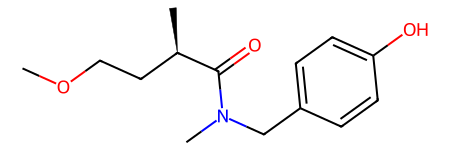

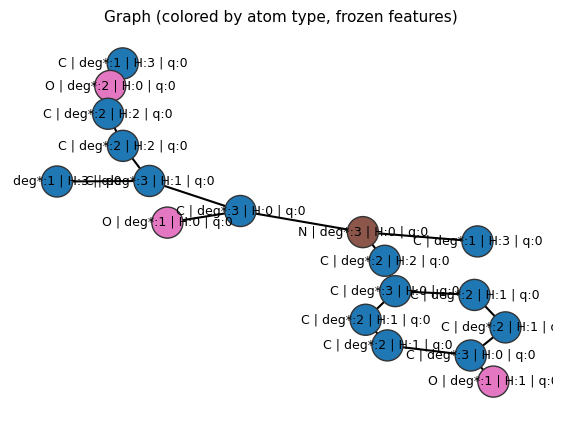

Counter({(1, 1, 0, 1): 4, (1, 0, 0, 3): 3, (1, 1, 0, 2): 3, (1, 2, 0, 0): 3, (1, 2, 0, 1): 1, (5, 2, 0, 0): 1, (6, 0, 0, 0): 1, (6, 0, 0, 1): 1, (6, 1, 0, 0): 1})
Total edges: 18
Total nodes: 18
Nodes: 2, Healthy Population: 14
Counter({(1, 1, 0, 1): 4, (1, 0, 0, 3): 3, (1, 1, 0, 2): 3, (1, 2, 0, 0): 2, (1, 2, 0, 1): 1, (5, 2, 0, 0): 1, (6, 0, 0, 0): 1, (6, 1, 0, 0): 1})
Counter({(1, 1, 0, 1): 4, (1, 1, 0, 2): 3, (1, 2, 0, 0): 3, (1, 0, 0, 3): 2, (1, 2, 0, 1): 1, (6, 0, 0, 0): 1, (6, 0, 0, 1): 1, (6, 1, 0, 0): 1})
Counter({(1, 1, 0, 1): 4, (1, 0, 0, 3): 3, (1, 2, 0, 0): 3, (1, 1, 0, 2): 2, (5, 2, 0, 0): 1, (6, 0, 0, 0): 1, (6, 0, 0, 1): 1, (6, 1, 0, 0): 1})
Counter({(1, 0, 0, 3): 3, (1, 1, 0, 1): 3, (1, 1, 0, 2): 3, (1, 2, 0, 0): 2, (1, 2, 0, 1): 1, (5, 2, 0, 0): 1, (6, 0, 0, 0): 1, (6, 0, 0, 1): 1, (6, 1, 0, 0): 1})
Counter({(1, 1, 0, 1): 4, (1, 0, 0, 3): 3, (1, 1, 0, 2): 2, (1, 2, 0, 0): 2, (1, 2, 0, 1): 1, (5, 2, 0, 0): 1, (6, 0, 0, 0): 1, (6, 0, 0, 1): 1, (6, 1, 0, 0): 1})
Counter(

In [19]:
def total_edges_count(ctr: Counter) -> int:
    return sum(e_idx+1 for _, e_idx, _, _ in ctr)


# Constants
max_population_size = 32

# Goal
idx = 1
data = batch.to_data_list()[idx]
mol = Chem.MolFromSmiles(data.smiles)
display(mol)
full_graph_nx = pyg_to_nx(data)
ax2_full = draw_with_atom_coloring(full_graph_nx)
plt.show()
full_ctr = nodes_decoded_counter[idx]
print(full_ctr)
total_edges = total_edges_count(full_ctr)
total_nodes = full_ctr.total()
oracle = is_induced_subgraph_feature_aware
print("Total edges:", total_edges)
print("Total nodes:", total_nodes)
feat_counter = order_leftovers_by_degree_distinct(full_ctr)
## Initialization the intial population, all the distinct graphs with 2 nodes
## In this stage we also save the results of the orcale, to be used in later stages, since
## here we can determine if generally an edge exist between two node types
global_seen = set()
first_population_cands = []
for i in range(len(feat_counter)):
    for j in range(i, len(feat_counter)):
        u = feat_counter[i]
        v = feat_counter[j]
        ## Valid sub graph should have at least one node with residual > 0
        if u[1] == 0 and v[1] == 0:
            continue
        if u == v and full_ctr[u] > 1:
            first_population_cands.append((u, v))
        elif u != v:
            first_population_cands.append((u, v))

## Materialize first candidates
draw = False
first_pop = set()
for u, v in first_population_cands:
    G = nx.Graph()
    u_id = add_node_with_feat(G, Feat.from_tuple(u))
    add_node_and_connect(G, Feat.from_tuple(v), connect_to=[u_id])
    key = dedup_key(G)
    if key not in global_seen:
        global_seen.add(key)
        first_pop.add(G)
    if draw:
        ax2 = draw_with_atom_coloring(G)
        plt.show()


## Use oracle to select the healthy population
healthy_pop = set()
for p in first_pop:
    if oracle(p, full_graph_nx):
        if len(healthy_pop) < max_population_size:
            healthy_pop.add(p)
print("Nodes: 2, Healthy Population:", len(healthy_pop))

## expand the healthy population
## Until the final graph is detected, considering the total_number of nodes and total_number of
## edes possible in the final graph and not exceeding that.
new_population = set()
for p in healthy_pop:
    ctr = feature_counter_from_graph(p)
    leftovers_ctr = leftover_features(full_ctr, p)
    print(leftovers_ctr)
    ## get the possible anchors
    ancrs = anchors(p)
    feat_counter = order_leftovers_by_degree_distinct(leftovers_ctr)
    ## For each possible anchor add one node to from the leftovers
    for a in ancrs:
        for lo in leftovers_ctr:
            ## If we know our oracle is good, we could use the results of the initial population
            ## to skip the edges between two node types that does not exists (rejected by the oracle)
            G = p.copy()
            nid = add_node_and_connect(G, Feat.from_tuple(lo), connect_to=[a])
            if not nid:
                continue
            key = dedup_key(G)
            if key not in global_seen:
                global_seen.add(key)
                new_population.add(G)
            ## Try all the legal edges from the new node to the existing anchors on the new graph
            new_anchors = anchors(G)
            for a in new_anchors:
                G_clone = G.copy()
                has_added = add_edge_if_possible(G_clone, u=a, v=nid)
                ## If by adding this edge we don't exceed the total edges, add
                key = dedup_key(G_clone)
                if has_added and int(G_clone.number_of_edges()) >= total_edges and key not in global_seen:
                    global_seen.add(key)
                    new_population.add(G_clone)


## Use oracle to select the healthy population
new_healthy_pop = set()
for p in new_population:
    if oracle(p, full_graph_nx):
        if len(new_healthy_pop) < max_population_size:
            new_healthy_pop.add(p)
print("Nodes: 3, Healthy Population:", len(new_healthy_pop))
## now repeat until the final graph reaches or no final graph reaches, return empty list/set


In [30]:
from src.utils.utils import TupleIndexer
from torchhd import VSATensor
import torchhd
# ---------------------------
# Decoder
# ---------------------------

def greedy_oracle_decoder(
        node_multiset: Counter,
        oracle: callable,
        full_graph_hv,
        *,
        beam_size: int = 32,
        draw: bool = False,
):
    """Greedy/beam search decoder outline using an oracle.

    :param draw: if draw the sub graphs
    :param node_multiset: Multiset of target node features (final graph nodes).
    :param oracle: Callable that scores/filters a candidate. Prefer passing a closure
                   that captures the truth graph, so it can be called as `oracle(G)`.
                   If your oracle has signature `(G, truth)`, this function will try
                   `oracle(G, full_graph_nx)` where `full_graph_nx` must exist globally.
    :param beam_size: Max population size to keep each iteration.
    :return: List of candidate graphs (ideally size 1 at the end).
    """
    full_ctr: Counter = node_multiset.copy()
    total_edges = total_edges_count(full_ctr)
    total_nodes = sum(full_ctr.values())

    # -- local helpers kept INSIDE for easy modification --

    def _wl_hash(G: nx.Graph, *, iters: int = 3) -> str:
        """WL hash that respects `feat`."""
        H = G.copy()
        for n in H.nodes:
            f = H.nodes[n]["feat"]
            H.nodes[n]["__wl_label__"] = ",".join(map(str, f.to_tuple()))
        return nx.weisfeiler_lehman_graph_hash(H, node_attr="__wl_label__", iterations=iters)

    def _dedup_key(G: nx.Graph) -> Tuple[str, int, int]:
        return (_wl_hash(G), G.number_of_nodes(), G.number_of_edges())

    def _order_leftovers_by_degree_distinct(ctr: Counter) -> List[Tuple[int, int, int, int]]:
        """Unique feature tuples, sorted by final degree (asc), then lexicographically."""
        uniq = list(ctr.keys())
        uniq.sort(key=lambda t: (t[1] + 1, t))
        return uniq

    def _call_oracle(G: nx.Graph) -> bool:
        """Call oracle as `oracle(G)`; if that fails, try `oracle(G, full_graph_nx)`."""
        try:
            # prefer 1-arg oracle (closure/partial)
            return bool(oracle(G))
        except TypeError:
            # fall back to 2-arg form using a global like in your draft
            try:
                return bool(oracle(G, full_graph_nx))  # noqa: F821 (expected in caller globals)
            except NameError as e:
                raise RuntimeError(
                    "Oracle appears to require two arguments; "
                    "please pass a functools.partial(mocked_oracle, g2=full_graph_nx) "
                    "or ensure `full_graph_nx` is defined globally."
                ) from e

    # Cache: from a 2-node test we can learn if an edge between two feature types is plausible.
    # Key is an ordered pair of feature tuples (t_small, t_big) with t_small <= t_big.
    pair_ok: Dict[Tuple[Tuple[int,int,int,int], Tuple[int,int,int,int]], bool] = {}

    # Global dedup across the whole search (WL hash based)
    global_seen: set = set()

    # ---------------------------
    # 1) Initial population (2-node graphs)
    # ---------------------------

    feat_types = _order_leftovers_by_degree_distinct(full_ctr)

    # build all distinct ordered pairs (i <= j) where at least one has residual > 0 (deg_idx > 0)
    first_pairs: List[Tuple[Tuple[int,int,int,int], Tuple[int,int,int,int]]] = []
    for i in range(len(feat_types)):
        for j in range(i, len(feat_types)):
            u = feat_types[i]
            v = feat_types[j]
            # skip impossible 0-0 pair (both final degree == 0)
            if u[1] == 0 and v[1] == 0:
                continue
            # require multiplicity when u == v
            if u == v and full_ctr[u] < 2:
                continue
            first_pairs.append((u, v))

    # materialize 2-node candidates
    first_pop: List[nx.Graph] = []
    for u_t, v_t in first_pairs:
        G = nx.Graph()
        uid = add_node_with_feat(G, Feat.from_tuple(u_t))
        _ = add_node_and_connect(G, Feat.from_tuple(v_t), connect_to=[uid])  # may attach or fail
        # if attachment failed (shouldn't, unless deg==0 on v_t), ensure at least nodes exist
        if G.number_of_nodes() < 2:
            vid = add_node_with_feat(G, Feat.from_tuple(v_t))
            # try to connect if feasible
            add_edge_if_possible(G, uid, vid, strict=True)

        key = _dedup_key(G)
        if key in global_seen:
            continue
        global_seen.add(key)
        first_pop.append(G)

        indexer: TupleIndexer = hypernet.nodes_indexer
        u_t_hv: VSATensor = hypernet.nodes_codebook[indexer.get_idx(u_t)]
        v_t_hv: VSATensor = hypernet.nodes_codebook[indexer.get_idx(v_t)]

        edge_in = u_t_hv.bind(v_t_hv)
        edge_out = v_t_hv.bind(u_t_hv)
        edge_bi = edge_in.bundle(edge_out)

        s_in = torchhd.dot(full_graph_hv, edge_in)
        s_out = torchhd.dot(full_graph_hv, edge_out)
        s_bi = torchhd.dot(full_graph_hv, edge_bi)
        print(f"==={u_t}-{v_t}===")
        print(f"{oracle(G, full_graph_nx)=}")
        print(f"{s_in.item()=}")
        print(f"{s_out.item()=}")
        print(f"{s_bi.item()=}")


    print(f"First population size: {len(first_pop)}")

    # oracle filter for 2-node graphs; also learn pair feasibility
    healthy_pop: List[nx.Graph] = []
    for G in first_pop:
        ok = _call_oracle(G)
        print()
        # learn pair feasibility from G (it has 1 or 0 edges)
        if G.number_of_nodes() == 2:
            nodes = list(G.nodes)
            t0 = G.nodes[nodes[0]]["feat"].to_tuple()
            t1 = G.nodes[nodes[1]]["feat"].to_tuple()
            k = tuple(sorted((t0, t1)))
            pair_ok[k] = bool(G.number_of_edges() == 1 and ok)
        if ok:
            healthy_pop.append(G)
    # Don't limit the first population
    print(f"Healthy population size: {len(healthy_pop)}")

    print("Printing cos similarity matrix...")


    if not healthy_pop:
        return []

    # ---------------------------
    # 2) Iterative expansion
    # ---------------------------

    population = healthy_pop
    # loop until we place all nodes; guard with max_iters to avoid infinite loops
    max_iters = total_nodes + 5
    iters = 0

    while iters < max_iters:
        iters += 1
        print(f"Iteration: {iters} | max pop: {len(population)}")
        if draw:
            print("Drawings...")
            for G in population:
                ax = draw_with_atom_coloring(G)
                plt.show()

        # Check if any candidate already has all nodes placed
        done = []
        still_growing = []
        for G in population:
            left = leftover_features(full_ctr, G)
            if not left:
                done.append(G)
            else:
                still_growing.append(G)

        # If we have any 'done' graphs, try to finish edges if needed (optional) and return them
        if done:
            # If desired, you can attempt to add remaining edges among anchors here.
            # For now, return those that don't exceed the total edge budget.
            finals = [g for g in done if g.number_of_edges() <= total_edges]
            # Prefer fully saturated (all residuals zero)
            def _all_saturated(g: nx.Graph) -> bool:
                return all((g.nodes[n]["target_degree"] - g.degree[n]) == 0 for n in g.nodes)
            finals.sort(key=lambda g: (_all_saturated(g), g.number_of_edges()), reverse=True)
            return finals[:beam_size]

        # Expand each growing candidate by adding ONE new node connected to ONE anchor,
        # then optionally one extra edge from the new node to another anchor.
        children: List[nx.Graph] = []
        local_seen: set = set()  # per-iteration dedup to keep branching under control

        for G in population:
            leftovers_ctr = leftover_features(full_ctr, G)
            if not leftovers_ctr:
                continue

            # choose types in ascending final degree (distinct types)
            leftover_types = _order_leftovers_by_degree_distinct(leftovers_ctr)
            ancrs = anchors(G)
            if not ancrs:
                # cannot expand this candidate
                continue

            # Enumerate attachments
            for a in ancrs:
                a_t = G.nodes[a]["feat"].to_tuple()
                for lo_t in leftover_types:
                    # Early prune using 2-node oracle knowledge (if seen and false)
                    k = tuple(sorted((a_t, lo_t)))
                    if k in pair_ok and pair_ok[k] is False:
                        continue

                    H = G.copy()
                    nid = add_node_and_connect(H, Feat.from_tuple(lo_t), connect_to=[a])
                    if nid is None:
                        continue

                    # Do not exceed target total edges
                    if H.number_of_edges() > total_edges:
                        continue

                    key = _dedup_key(H)
                    if key not in global_seen and key not in local_seen:
                        global_seen.add(key); local_seen.add(key)
                        children.append(H)

                    # Optionally try adding ONE more edge from new node to another anchor
                    # (keeps branching modest; you can widen this later if needed)
                    H_anchors = anchors(H)
                    for b in H_anchors:
                        if b == nid:
                            continue
                        H2 = H.copy()
                        if add_edge_if_possible(H2, b, nid, strict=True):
                            if H2.number_of_edges() <= total_edges:
                                key2 = _dedup_key(H2)
                                if key2 not in global_seen and key2 not in local_seen:
                                    global_seen.add(key2); local_seen.add(key2)
                                    children.append(H2)

        if not children:
            # No more expansions possible
            return population

        # Oracle filter children
        accepted: List[nx.Graph] = []
        for H in children:
            if _call_oracle(H):
                accepted.append(H)
                if len(accepted) >= beam_size:
                    break

        if not accepted:
            # Oracle rejected all; stop with current population
            return population

        # Next generation
        population = accepted

    # Safeguard exit
    return population

-----------------


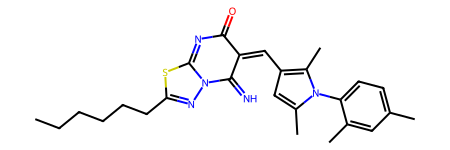

Original Graph


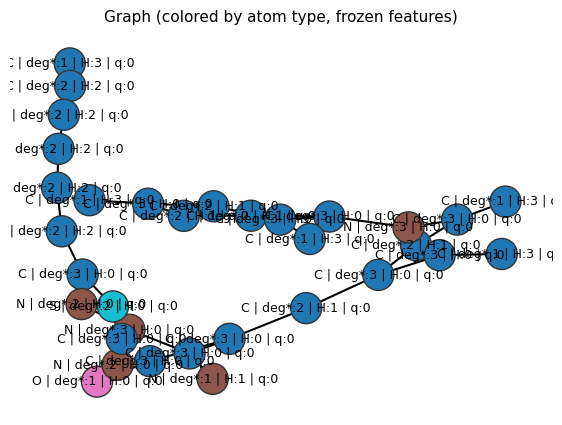

Counter({(1, 2, 0, 0): 11, (1, 0, 0, 3): 5, (1, 1, 0, 1): 5, (1, 1, 0, 2): 5, (5, 1, 0, 0): 2, (5, 2, 0, 0): 2, (5, 0, 0, 1): 1, (6, 0, 0, 0): 1, (7, 2, 1, 0): 1, (8, 1, 0, 0): 1})
===(1, 0, 0, 3)-(1, 1, 0, 1)===
oracle(G, full_graph_nx)=False
s_in.item()=-77.11367797851562
s_out.item()=-77.11404418945312
s_bi.item()=-154.22731018066406
===(1, 0, 0, 3)-(1, 1, 0, 2)===
oracle(G, full_graph_nx)=True
s_in.item()=-1433.8477783203125
s_out.item()=-1433.8477783203125
s_bi.item()=-2867.693603515625
===(1, 0, 0, 3)-(5, 1, 0, 0)===
oracle(G, full_graph_nx)=False
s_in.item()=-587.1688842773438
s_out.item()=-587.168701171875
s_bi.item()=-1174.337646484375
===(1, 0, 0, 3)-(8, 1, 0, 0)===
oracle(G, full_graph_nx)=False
s_in.item()=-99.32403564453125
s_out.item()=-99.32406616210938
s_bi.item()=-198.64747619628906
===(1, 0, 0, 3)-(1, 2, 0, 0)===
oracle(G, full_graph_nx)=True
s_in.item()=416.20343017578125
s_out.item()=416.20343017578125
s_bi.item()=832.407958984375
===(1, 0, 0, 3)-(5, 2, 0, 0)===
ora

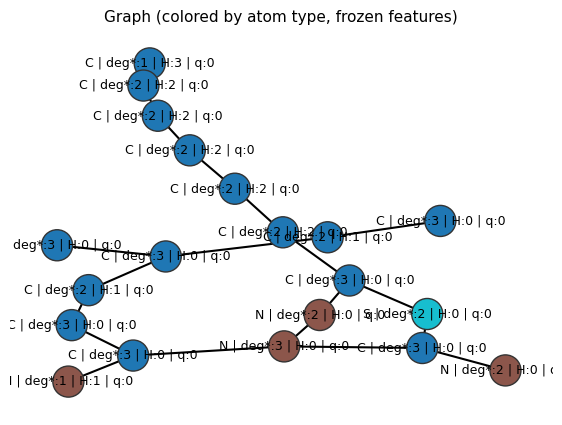

Is Induced subgraph:  True
Decoded Graph


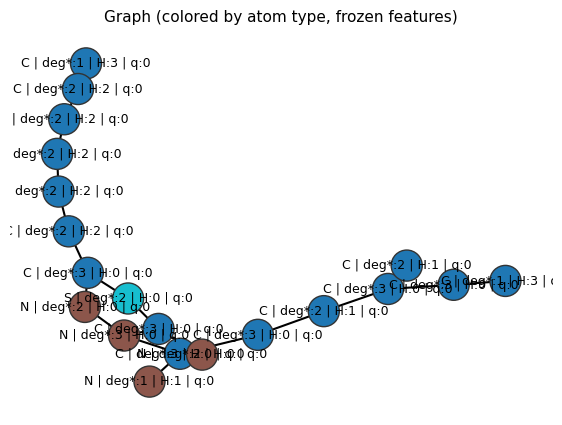

Is Induced subgraph:  True
Decoded Graph


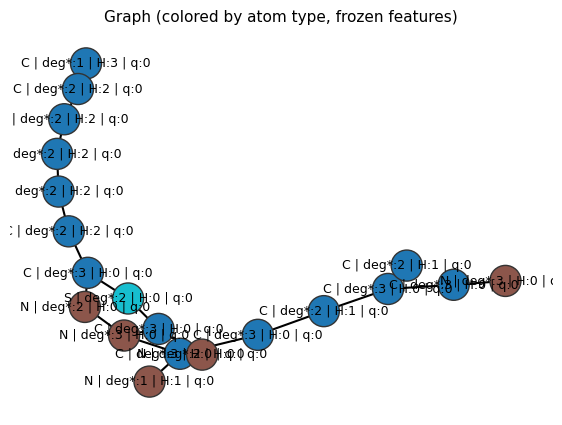

Is Induced subgraph:  True
-----------------


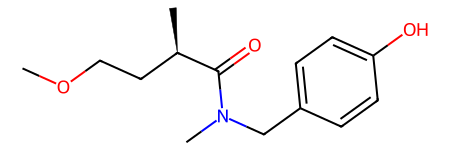

Original Graph


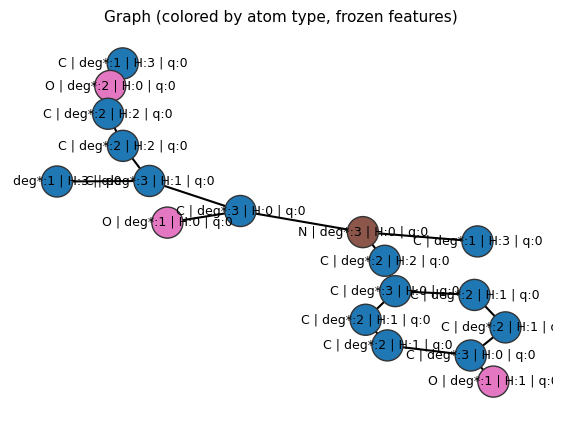

Counter({(1, 1, 0, 1): 4, (1, 0, 0, 3): 3, (1, 1, 0, 2): 3, (1, 2, 0, 0): 3, (1, 2, 0, 1): 1, (5, 2, 0, 0): 1, (6, 0, 0, 0): 1, (6, 0, 0, 1): 1, (6, 1, 0, 0): 1})
===(1, 0, 0, 3)-(1, 1, 0, 1)===
oracle(G, full_graph_nx)=False
s_in.item()=-139.61614990234375
s_out.item()=-139.6161651611328
s_bi.item()=-279.2323303222656
===(1, 0, 0, 3)-(1, 1, 0, 2)===
oracle(G, full_graph_nx)=False
s_in.item()=31.099510192871094
s_out.item()=31.099510192871094
s_bi.item()=62.198951721191406
===(1, 0, 0, 3)-(6, 1, 0, 0)===
oracle(G, full_graph_nx)=True
s_in.item()=90.11009216308594
s_out.item()=90.11001586914062
s_bi.item()=180.22015380859375
===(1, 0, 0, 3)-(1, 2, 0, 0)===
oracle(G, full_graph_nx)=False
s_in.item()=21.689651489257812
s_out.item()=21.689598083496094
s_bi.item()=43.379188537597656
===(1, 0, 0, 3)-(1, 2, 0, 1)===
oracle(G, full_graph_nx)=True
s_in.item()=86.79963684082031
s_out.item()=86.79962158203125
s_bi.item()=173.598876953125
===(1, 0, 0, 3)-(5, 2, 0, 0)===
oracle(G, full_graph_nx)=Tr

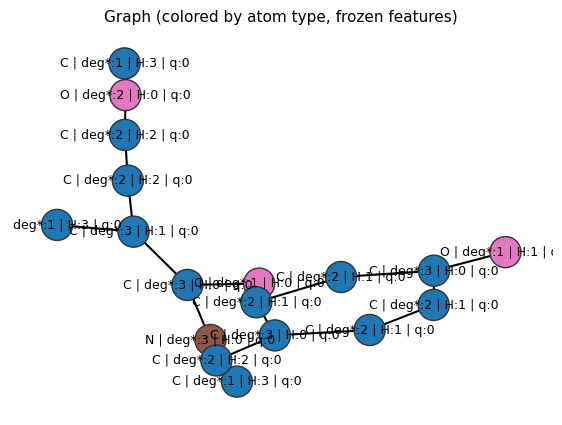

Is Induced subgraph:  True


In [31]:
# Constants
max_population_size = 4

# Goal
draw = False
n = min(batch_size, 8)
oracle = is_induced_subgraph_feature_aware
decoded_nx_graphs = []
for i, data in enumerate(batch.to_data_list()[:n]):
    print("-----------------")
    mol = Chem.MolFromSmiles(data.smiles)
    display(mol)
    full_graph_nx = pyg_to_nx(data)
    ax2_full = draw_with_atom_coloring(full_graph_nx)
    print("Original Graph")
    plt.show()
    full_ctr = nodes_decoded_counter[i]
    print(full_ctr)
    graphs = greedy_oracle_decoder(full_ctr, oracle=oracle, beam_size=max_population_size, draw=draw, full_graph_hv=graph_term[i])

    for g in graphs:
        ax = draw_with_atom_coloring(g)
        print("Decoded Graph")
        plt.show()
        print("Is Induced subgraph: ", oracle(g, full_graph_nx))


In [16]:
from __future__ import annotations
from typing import Dict, Tuple, Sequence, Optional
import networkx as nx
from rdkit import Chem

DEFAULT_ATOM_SYMBOLS: Sequence[str] = ['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']
FORMAL_CHARGE_IDX_TO_VAL: Dict[int, int] = {0: 0, 1: +1, 2: -1}

def nx_to_mol(
    G: nx.Graph,
    *,
    atom_symbols: Sequence[str] = DEFAULT_ATOM_SYMBOLS,
    infer_bonds: bool = True,
    set_no_implicit: bool = True,
    set_explicit_hs: bool = True,
    set_atom_map_nums: bool = False,
    sanitize: bool = True,
    kekulize: bool = True,
    validate_heavy_degree: bool = False,
) -> Tuple["Chem.Mol", Dict[int, int]]:
    """
    Build an RDKit molecule from an **undirected** NetworkX graph with frozen features.

    Each node must have ``feat`` as a 4-tuple: ``(atom_type_idx, degree_idx, charge_idx, explicit_hs)``,
    or an object with ``to_tuple()`` returning that tuple.

    If ``infer_bonds=True``, a greedy valence-based routine assigns DOUBLE/TRIPLE bonds to reduce
    per-atom valence deficits (based on element & formal charge) before constructing the RDKit bonds.

    :param G: Undirected graph; node['feat'] is frozen feature tuple.
    :param atom_symbols: Mapping from atom_type_idx to element symbol.
    :param infer_bonds: If True, infer bond orders from valence targets; otherwise use SINGLE bonds.
    :param set_no_implicit: Set ``NoImplicit=True`` so RDKit won’t alter explicit H counts.
    :param set_explicit_hs: Apply ``NumExplicitHs`` from features.
    :param set_atom_map_nums: Annotate RDKit atoms with original NX ids (debug).
    :param sanitize: Run ``Chem.SanitizeMol`` (may fail if bonding is chemically impossible).
    :param kekulize: Try ``Chem.Kekulize`` after sanitize.
    :param validate_heavy_degree: Assert NX heavy degree equals ``degree_idx+1`` for all nodes.
    :returns: (mol, nx_to_rd_index_map)

    .. note::
       This inference is **heuristic** and not guaranteed to match real chemistry.
       If sanitize fails, the function falls back to SINGLE bonds (unless you set ``sanitize=False``).
    """
    def _as_tuple(feat_obj) -> Tuple[int, int, int, int]:
        if hasattr(feat_obj, "to_tuple"):
            t = feat_obj.to_tuple()
        else:
            t = tuple(int(x) for x in feat_obj)
        if len(t) != 4:
            raise ValueError(f"feat must be a 4-tuple, got {t}")
        return t

    # --- unpack features & basic guards ---
    feats: Dict[int, Tuple[int,int,int,int]] = {}
    symbols: Dict[int, str] = {}
    charges: Dict[int, int] = {}
    expHs: Dict[int, int] = {}
    target_deg: Dict[int, int] = {}

    for n in G.nodes:
        t = _as_tuple(G.nodes[n]["feat"])
        at_idx, deg_idx, ch_idx, hs = t
        if not (0 <= at_idx < len(atom_symbols)):
            raise ValueError(f"atom_type_idx out of range on node {n}: {at_idx}")
        sym = atom_symbols[at_idx]
        ch = FORMAL_CHARGE_IDX_TO_VAL.get(int(ch_idx), int(ch_idx))
        feats[n] = (at_idx, deg_idx, ch_idx, hs)
        symbols[n] = sym
        charges[n] = int(ch)
        expHs[n] = int(hs)
        target_deg[n] = int(deg_idx) + 1  # heavy neighbors count

    if validate_heavy_degree:
        for n in G.nodes:
            if G.degree[n] != target_deg[n]:
                raise AssertionError(f"Heavy degree mismatch at node {n}: NX={G.degree[n]} vs target={target_deg[n]}")

    # --- optional bond-order inference on the NX graph ---
    # Bond orders: dict of undirected edge -> order (1,2,3)
    order: Dict[Tuple[int,int], int] = {}
    for u, v in G.edges:
        a, b = (u, v) if u < v else (v, u)
        order[(a, b)] = 1  # start with single

    if infer_bonds and G.number_of_edges() > 0:
        # Element valence "menus" (very rough, neutral-first; charged variants added where common)
        # Chosen valence is the **smallest** >= current usage to avoid over-bonding.
        valence_menu = {
            "C": {0: (4,),  -1: (3,4),  +1: (3,)},
            "N": {0: (3,5), -1: (2,3),  +1: (4,)},
            "O": {0: (2,),  -1: (1,2),  +1: (3,)},
            "P": {0: (3,5), +1: (4,5)},
            "S": {0: (2,4,6), +1: (3,5), -1: (1,2)},
            "F": {0: (1,)}, "Cl": {0: (1,)}, "Br": {0: (1,)}, "I": {0: (1,)},
        }

        # ring preference: small cycles first
        try:
            cycles = nx.cycle_basis(G)
        except Exception:
            cycles = []
        ring_edges = set()
        for cyc in cycles:
            for i in range(len(cyc)):
                a, b = cyc[i], cyc[(i+1) % len(cyc)]
                a, b = (a, b) if a < b else (b, a)
                ring_edges.add((a, b))

        def current_usage(n: int) -> int:
            """Valence usage = explicit Hs + sum(bond orders to heavy neighbors)."""
            s = expHs[n]
            for nb in G.neighbors(n):
                a, b = (n, nb) if n < nb else (nb, n)
                s += order[(a, b)]
            return s

        def target_valence(n: int) -> int:
            sym = symbols[n]; ch = charges[n]
            menu = valence_menu.get(sym, {0: (target_deg[n] + expHs[n],)})
            opts = menu.get(ch, menu.get(0, (target_deg[n] + expHs[n],)))
            used = current_usage(n)
            for v in sorted(opts):
                if v >= used:
                    return v
            return max(opts)

        # Greedy raise orders until deficits vanish or stuck
        def deficit(n: int) -> int:
            return max(0, target_valence(n) - current_usage(n))

        # atoms priority: hetero first, then carbons, larger deficit first
        hetero = {"N","O","S","P"}
        def atom_priority(n: int) -> Tuple[int,int]:
            return (1 if symbols[n] in hetero else 0, deficit(n))

        # bond escalation priority: prefer ring edges and hetero involvement
        def bond_priority(u: int, v: int) -> Tuple[int,int,int]:
            a, b = (u, v) if u < v else (v, u)
            in_ring = 1 if (a, b) in ring_edges else 0
            hetero_count = int(symbols[u] in hetero) + int(symbols[v] in hetero)
            return (in_ring, hetero_count, order[(a, b)])

        changed = True
        iters = 0
        MAX_ITERS = 4 * G.number_of_edges()
        while changed and iters < MAX_ITERS:
            iters += 1
            changed = False

            # collect candidate atoms with positive deficit
            cand_atoms = [n for n in G.nodes if deficit(n) > 0]
            if not cand_atoms:
                break

            # sort atoms by priority (hetero, deficit)
            cand_atoms.sort(key=lambda n: atom_priority(n), reverse=True)

            for n in cand_atoms:
                if deficit(n) <= 0:
                    continue
                # choose neighbor with deficit and smallest current order, with bond priority
                nbs = [m for m in G.neighbors(n) if deficit(m) > 0 and order[(n, m) if n < m else (m, n)] < 3]
                if not nbs:
                    continue
                # sort neighbors/bonds by ring & hetero preference, then lowest existing order
                nbs.sort(key=lambda m: bond_priority(n, m), reverse=True)
                m = nbs[0]
                a, b = (n, m) if n < m else (m, n)
                # bump bond order by 1
                order[(a, b)] += 1
                changed = True

        # Optional final clip: avoid absurd orders on halogens
        for (a, b), bo in list(order.items()):
            if symbols[a] in ("F","Cl","Br","I") or symbols[b] in ("F","Cl","Br","I"):
                order[(a, b)] = min(order[(a, b)], 1)

    # --- build RDKit RWMol ---
    rw = Chem.RWMol()
    nx_to_rd: Dict[int, int] = {}
    for n in sorted(G.nodes):
        at_idx, deg_idx, ch_idx, hs = feats[n]
        sym = symbols[n]
        ch = charges[n]
        atom = Chem.Atom(sym)
        atom.SetFormalCharge(int(ch))
        if set_explicit_hs:
            atom.SetNumExplicitHs(int(hs))
        if set_no_implicit:
            atom.SetNoImplicit(True)
        rd_idx = rw.AddAtom(atom)
        nx_to_rd[n] = rd_idx

    # add bonds with (possibly inferred) orders
    for u, v in G.edges:
        a, b = (u, v) if u < v else (v, u)
        bo = order.get((a, b), 1)
        bt = Chem.BondType.SINGLE if bo == 1 else Chem.BondType.DOUBLE if bo == 2 else Chem.BondType.TRIPLE
        rw.AddBond(nx_to_rd[u], nx_to_rd[v], bt)

    mol = rw.GetMol()

    if set_atom_map_nums:
        for n, rd_idx in nx_to_rd.items():
            mol.GetAtomWithIdx(rd_idx).SetAtomMapNum(int(n))

    if sanitize:
        try:
            Chem.SanitizeMol(mol)
            if kekulize:
                try:
                    Chem.Kekulize(mol, clearAromaticFlags=True)
                except Exception:
                    pass
        except Exception:
            # fallback: rebuild with single bonds if sanitize fails
            rw2 = Chem.RWMol()
            idx_map = {}
            for n in sorted(G.nodes):
                at_idx, deg_idx, ch_idx, hs = feats[n]
                sym = symbols[n]; ch = charges[n]
                a = Chem.Atom(sym); a.SetFormalCharge(int(ch))
                if set_explicit_hs: a.SetNumExplicitHs(int(expHs[n]))
                if set_no_implicit: a.SetNoImplicit(True)
                idx_map[n] = rw2.AddAtom(a)
            for u, v in G.edges:
                rw2.AddBond(idx_map[u], idx_map[v], Chem.BondType.SINGLE)
            mol = rw2.GetMol()
            if set_atom_map_nums:
                for n, rd_idx in idx_map.items():
                    mol.GetAtomWithIdx(rd_idx).SetAtomMapNum(int(n))
            if sanitize:
                # try a gentle sanitize (may still fail if graph is impossible chemically)
                try:
                    Chem.SanitizeMol(mol)
                except Exception:
                    pass

    return mol, nx_to_rd

-----------------


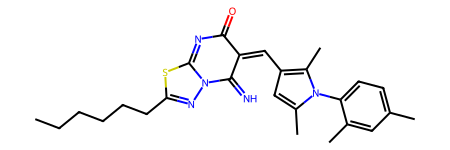

Original Graph


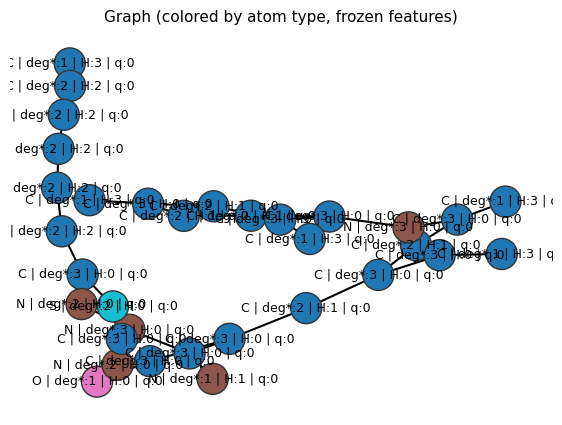

Counter({(1, 2, 0, 0): 11, (1, 0, 0, 3): 5, (1, 1, 0, 1): 5, (1, 1, 0, 2): 5, (5, 1, 0, 0): 2, (5, 2, 0, 0): 2, (5, 0, 0, 1): 1, (5, 5, 0, 0): 1, (6, 0, 0, 0): 1, (8, 1, 0, 0): 1})
First population size: 47
Healthy population size: 13
Iteration: 1 | max pop: 13
Iteration: 2 | max pop: 4
Iteration: 3 | max pop: 4
Iteration: 4 | max pop: 4
Iteration: 5 | max pop: 4
Iteration: 6 | max pop: 4
Iteration: 7 | max pop: 4
Iteration: 8 | max pop: 4
Iteration: 9 | max pop: 4
Iteration: 10 | max pop: 4
Iteration: 11 | max pop: 4
Iteration: 12 | max pop: 4
Iteration: 13 | max pop: 4
Iteration: 14 | max pop: 4
Iteration: 15 | max pop: 4
Iteration: 16 | max pop: 4
Iteration: 17 | max pop: 4
Iteration: 18 | max pop: 4
Iteration: 19 | max pop: 4
Iteration: 20 | max pop: 4
Iteration: 21 | max pop: 4
Iteration: 22 | max pop: 4
Iteration: 23 | max pop: 4
Iteration: 24 | max pop: 4
Iteration: 25 | max pop: 4
Iteration: 26 | max pop: 4
Iteration: 27 | max pop: 4
Iteration: 28 | max pop: 4
Iteration: 29 | m

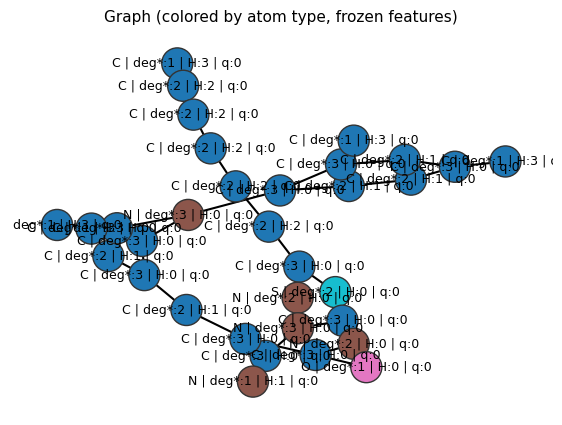

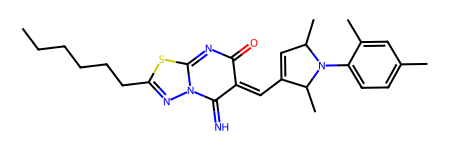

Is Induced subgraph:  True
-----------------


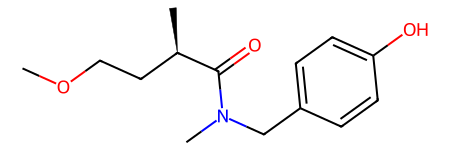

Original Graph


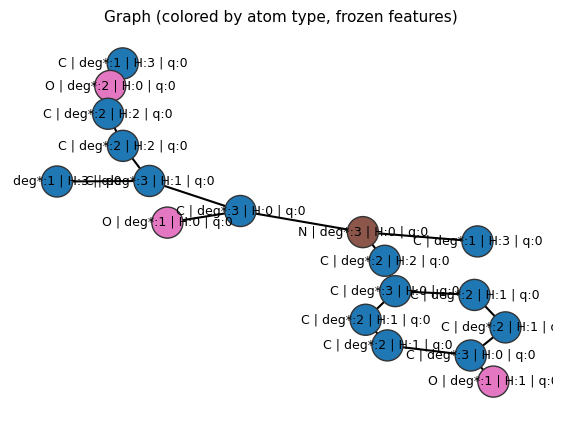

Counter({(1, 1, 0, 1): 4, (1, 0, 0, 3): 3, (1, 1, 0, 2): 3, (1, 2, 0, 0): 3, (1, 2, 0, 1): 1, (5, 2, 0, 0): 1, (6, 0, 0, 0): 1, (6, 0, 0, 1): 1, (6, 1, 0, 0): 1})
First population size: 36
Healthy population size: 14
Iteration: 1 | max pop: 14
Iteration: 2 | max pop: 4
Iteration: 3 | max pop: 4
Iteration: 4 | max pop: 4
Iteration: 5 | max pop: 4
Iteration: 6 | max pop: 4
Iteration: 7 | max pop: 4
Iteration: 8 | max pop: 4
Iteration: 9 | max pop: 4
Iteration: 10 | max pop: 4
Iteration: 11 | max pop: 4
Iteration: 12 | max pop: 4
Iteration: 13 | max pop: 4
Iteration: 14 | max pop: 4
Iteration: 15 | max pop: 4
Iteration: 16 | max pop: 3
Iteration: 17 | max pop: 1
Decoded Graph


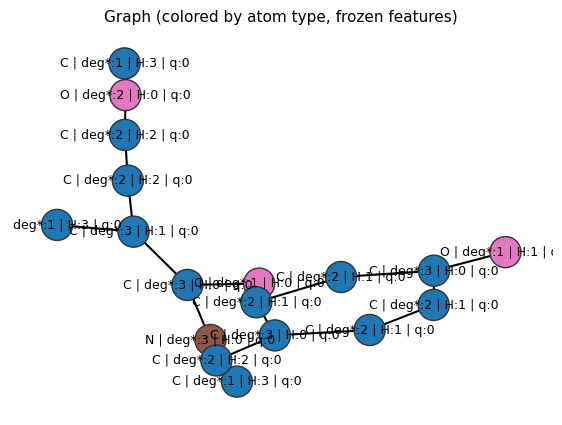

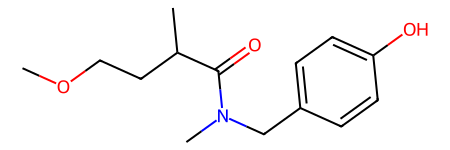

Is Induced subgraph:  True
-----------------


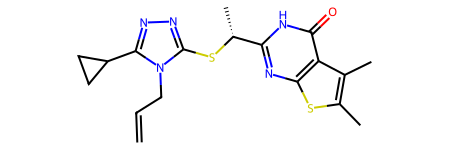

Original Graph


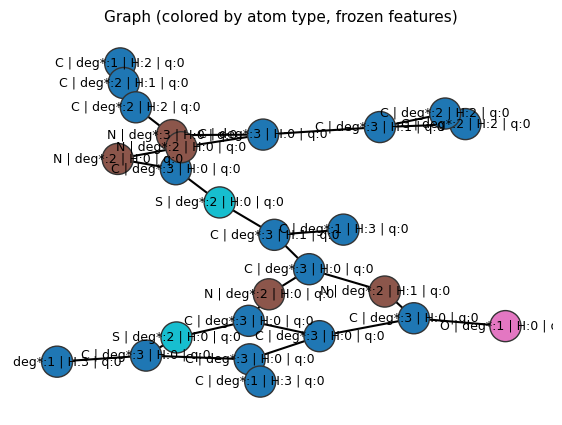

Counter({(1, 2, 0, 0): 8, (1, 0, 0, 3): 3, (1, 1, 0, 2): 3, (5, 1, 0, 0): 3, (1, 2, 0, 1): 2, (8, 1, 0, 0): 2, (1, 0, 0, 2): 1, (1, 1, 0, 1): 1, (5, 1, 0, 1): 1, (5, 2, 0, 0): 1, (6, 0, 0, 0): 1})
First population size: 57
Healthy population size: 16
Iteration: 1 | max pop: 16
Iteration: 2 | max pop: 4
Iteration: 3 | max pop: 4
Iteration: 4 | max pop: 4
Iteration: 5 | max pop: 4
Iteration: 6 | max pop: 4
Iteration: 7 | max pop: 4
Iteration: 8 | max pop: 4
Iteration: 9 | max pop: 4
Iteration: 10 | max pop: 4
Iteration: 11 | max pop: 4
Iteration: 12 | max pop: 4
Iteration: 13 | max pop: 4
Iteration: 14 | max pop: 4
Iteration: 15 | max pop: 4
Iteration: 16 | max pop: 4
Iteration: 17 | max pop: 4
Iteration: 18 | max pop: 4
Iteration: 19 | max pop: 4
Iteration: 20 | max pop: 4
Iteration: 21 | max pop: 4
Iteration: 22 | max pop: 4
Iteration: 23 | max pop: 4
Iteration: 24 | max pop: 3
Iteration: 25 | max pop: 1
Decoded Graph


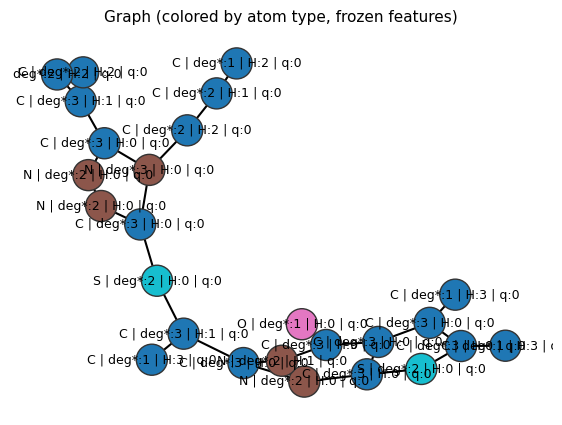

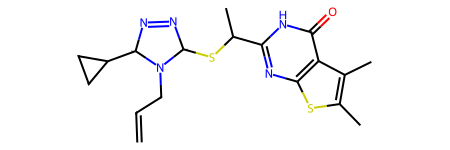

Is Induced subgraph:  True
-----------------


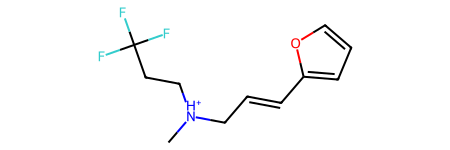

Original Graph


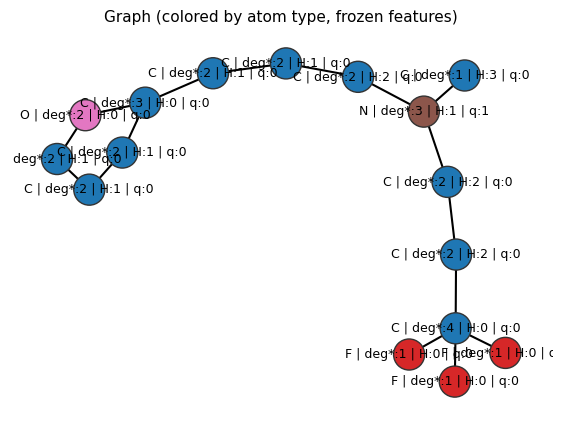

Counter({(1, 1, 0, 1): 5, (1, 1, 0, 2): 3, (3, 0, 0, 0): 3, (1, 0, 0, 3): 1, (1, 2, 0, 0): 1, (1, 3, 0, 0): 1, (5, 2, 1, 1): 1, (6, 1, 0, 0): 1})
First population size: 29
Healthy population size: 10
Iteration: 1 | max pop: 10
Iteration: 2 | max pop: 4
Iteration: 3 | max pop: 4
Iteration: 4 | max pop: 4
Iteration: 5 | max pop: 4
Iteration: 6 | max pop: 4
Iteration: 7 | max pop: 4
Iteration: 8 | max pop: 4
Iteration: 9 | max pop: 4
Iteration: 10 | max pop: 4
Iteration: 11 | max pop: 4
Iteration: 12 | max pop: 4
Iteration: 13 | max pop: 4
Iteration: 14 | max pop: 4
Iteration: 15 | max pop: 1
Decoded Graph


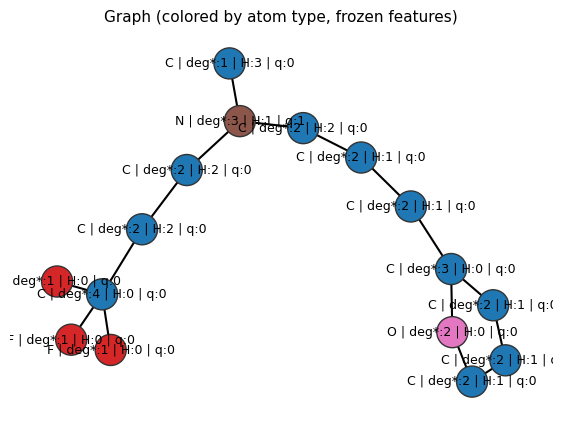

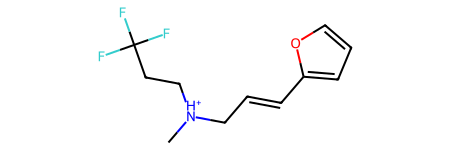

Is Induced subgraph:  True
-----------------


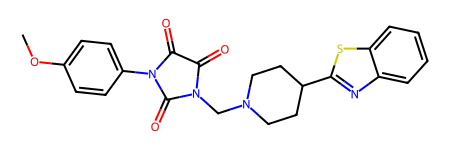

Original Graph


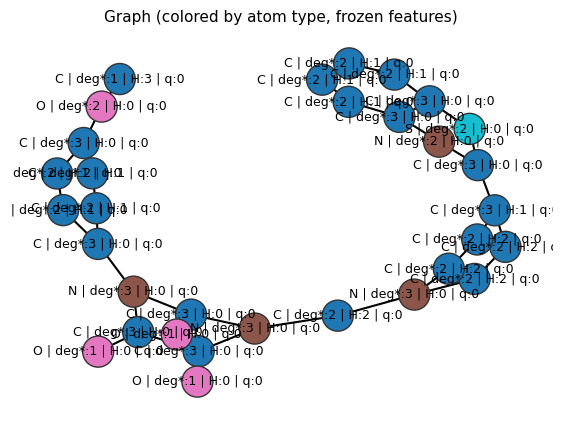

Counter({(1, 1, 0, 1): 8, (1, 2, 0, 0): 8, (1, 1, 0, 2): 5, (5, 2, 0, 0): 3, (6, 0, 0, 0): 3, (1, 0, 0, 3): 1, (1, 2, 0, 1): 1, (5, 1, 0, 0): 1, (6, 1, 0, 0): 1, (8, 1, 0, 0): 1})
First population size: 48
Healthy population size: 13
Iteration: 1 | max pop: 13
Iteration: 2 | max pop: 4
Iteration: 3 | max pop: 4
Iteration: 4 | max pop: 4
Iteration: 5 | max pop: 4
Iteration: 6 | max pop: 4
Iteration: 7 | max pop: 4
Iteration: 8 | max pop: 4
Iteration: 9 | max pop: 4
Iteration: 10 | max pop: 4
Iteration: 11 | max pop: 4
Iteration: 12 | max pop: 4
Iteration: 13 | max pop: 4
Iteration: 14 | max pop: 4
Iteration: 15 | max pop: 4
Iteration: 16 | max pop: 4
Iteration: 17 | max pop: 4
Iteration: 18 | max pop: 4
Iteration: 19 | max pop: 4
Iteration: 20 | max pop: 4
Iteration: 21 | max pop: 4
Iteration: 22 | max pop: 4
Iteration: 23 | max pop: 4
Iteration: 24 | max pop: 4
Iteration: 25 | max pop: 4
Iteration: 26 | max pop: 4
Iteration: 27 | max pop: 4
Iteration: 28 | max pop: 4
Iteration: 29 | ma

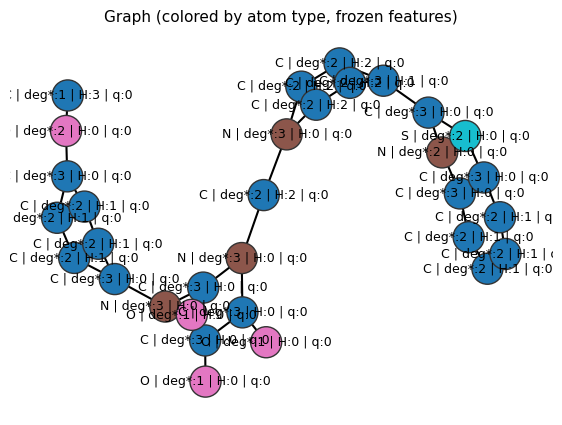

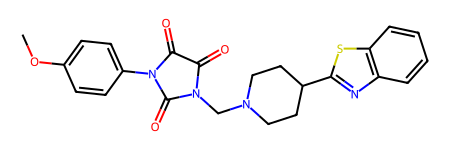

Is Induced subgraph:  True
-----------------


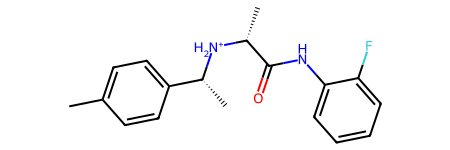

Original Graph


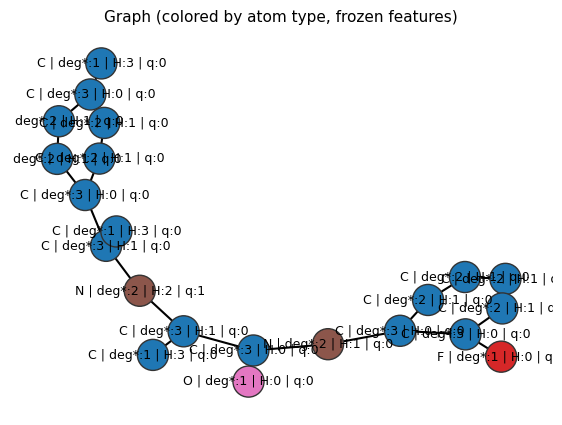

Counter({(1, 1, 0, 1): 8, (1, 2, 0, 0): 5, (1, 0, 0, 3): 3, (1, 2, 0, 1): 2, (3, 0, 0, 0): 1, (5, 1, 0, 1): 1, (5, 1, 1, 2): 1, (6, 0, 0, 0): 1})
First population size: 28
Healthy population size: 10
Iteration: 1 | max pop: 10
Iteration: 2 | max pop: 4
Iteration: 3 | max pop: 4
Iteration: 4 | max pop: 4
Iteration: 5 | max pop: 4
Iteration: 6 | max pop: 4
Iteration: 7 | max pop: 4
Iteration: 8 | max pop: 4
Iteration: 9 | max pop: 4
Iteration: 10 | max pop: 4
Iteration: 11 | max pop: 4
Iteration: 12 | max pop: 4
Iteration: 13 | max pop: 4
Iteration: 14 | max pop: 4
Iteration: 15 | max pop: 4
Iteration: 16 | max pop: 4
Iteration: 17 | max pop: 4
Iteration: 18 | max pop: 4
Iteration: 19 | max pop: 4
Iteration: 20 | max pop: 4
Iteration: 21 | max pop: 1
Decoded Graph


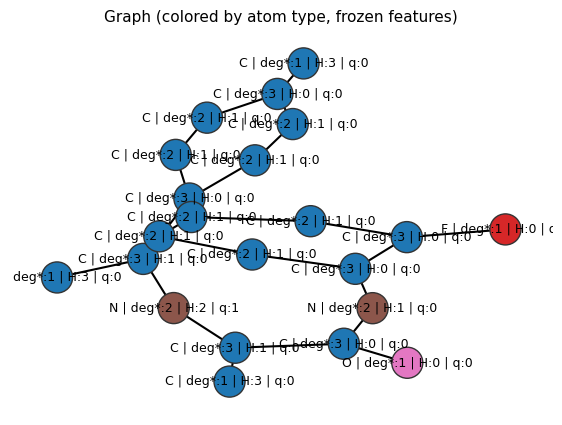

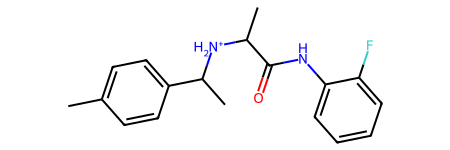

Is Induced subgraph:  True
-----------------


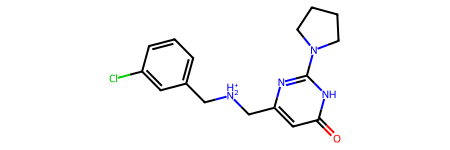

Original Graph


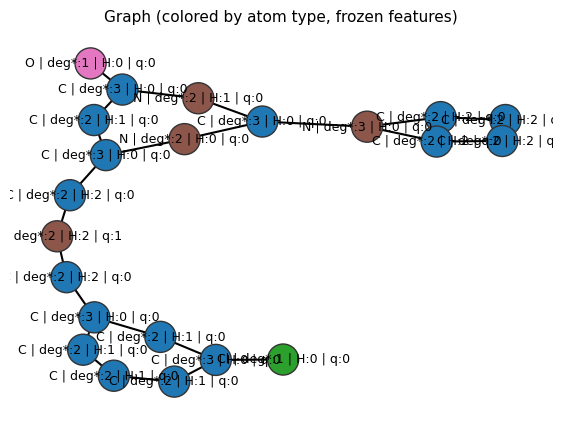

Counter({(1, 1, 0, 2): 6, (1, 1, 0, 1): 5, (1, 2, 0, 0): 5, (2, 0, 0, 0): 1, (5, 1, 0, 0): 1, (5, 1, 0, 1): 1, (5, 1, 1, 2): 1, (5, 2, 0, 0): 1, (6, 0, 0, 0): 1})
First population size: 38
Healthy population size: 11
Iteration: 1 | max pop: 11
Iteration: 2 | max pop: 4
Iteration: 3 | max pop: 4
Iteration: 4 | max pop: 4
Iteration: 5 | max pop: 4
Iteration: 6 | max pop: 4
Iteration: 7 | max pop: 4
Iteration: 8 | max pop: 4
Iteration: 9 | max pop: 4
Iteration: 10 | max pop: 4
Iteration: 11 | max pop: 4
Iteration: 12 | max pop: 4
Iteration: 13 | max pop: 4
Iteration: 14 | max pop: 4
Iteration: 15 | max pop: 4
Iteration: 16 | max pop: 4
Iteration: 17 | max pop: 4
Iteration: 18 | max pop: 4
Iteration: 19 | max pop: 4
Iteration: 20 | max pop: 3
Iteration: 21 | max pop: 1
Decoded Graph


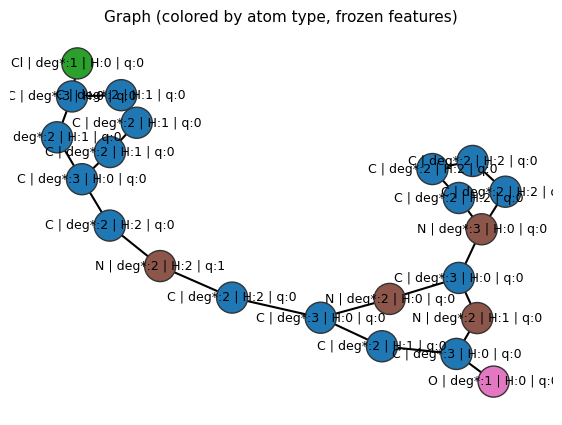

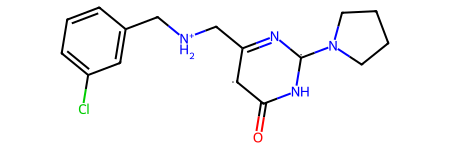

Is Induced subgraph:  True
-----------------


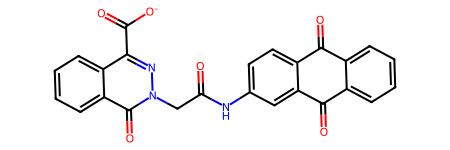

Original Graph


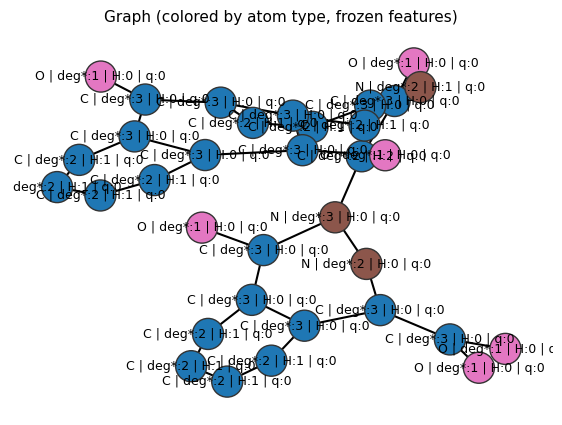

Counter({(1, 2, 0, 0): 13, (1, 1, 0, 1): 11, (6, 0, 0, 0): 5, (1, 1, 0, 2): 1, (4, 1, 2, 1): 1, (5, 1, 0, 0): 1, (5, 1, 0, 1): 1, (5, 2, 0, 0): 1, (5, 5, 0, 0): 1, (6, 0, 1, 3): 1, (6, 0, 2, 0): 1})
First population size: 54
Healthy population size: 11
Iteration: 1 | max pop: 11
Iteration: 2 | max pop: 4
Iteration: 3 | max pop: 4
Iteration: 4 | max pop: 4
Iteration: 5 | max pop: 4
Iteration: 6 | max pop: 4
Iteration: 7 | max pop: 4
Iteration: 8 | max pop: 4
Iteration: 9 | max pop: 4
Iteration: 10 | max pop: 4
Iteration: 11 | max pop: 4
Iteration: 12 | max pop: 4
Iteration: 13 | max pop: 4
Iteration: 14 | max pop: 4
Iteration: 15 | max pop: 4
Iteration: 16 | max pop: 4
Iteration: 17 | max pop: 4
Iteration: 18 | max pop: 4
Iteration: 19 | max pop: 4
Iteration: 20 | max pop: 4
Iteration: 21 | max pop: 4
Iteration: 22 | max pop: 4
Iteration: 23 | max pop: 4
Iteration: 24 | max pop: 4
Iteration: 25 | max pop: 4
Iteration: 26 | max pop: 4
Iteration: 27 | max pop: 4
Iteration: 28 | max pop: 4

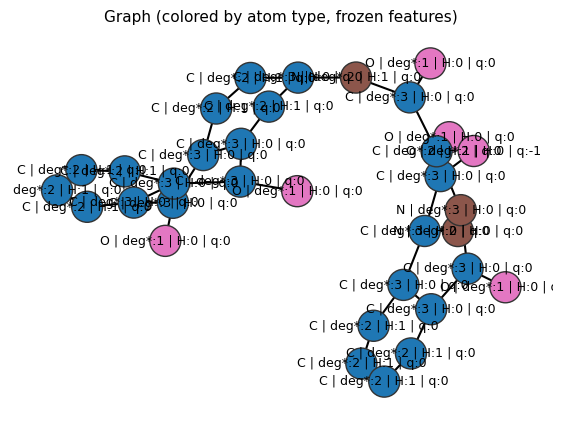

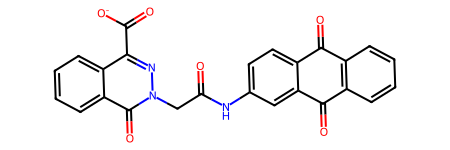

Is Induced subgraph:  True


In [17]:
# Constants
max_population_size = 4

# Goal
draw = False
n = min(batch_size, 8)
oracle = is_induced_subgraph_feature_aware
decoded_nx_graphs = []
for i, data in enumerate(batch.to_data_list()[:n]):
    print("-----------------")
    mol = Chem.MolFromSmiles(data.smiles)
    display(mol)
    full_graph_nx = pyg_to_nx(data)
    ax2_full = draw_with_atom_coloring(full_graph_nx)
    print("Original Graph")
    plt.show()
    full_ctr = nodes_decoded_counter[i]
    print(full_ctr)
    graphs = greedy_oracle_decoder(full_ctr, oracle=oracle, beam_size=max_population_size, draw=draw)

    for g in graphs:
        ax = draw_with_atom_coloring(g)
        print("Decoded Graph")
        plt.show()
        mol, _ = nx_to_mol(g)
        display(mol)
        print("Is Induced subgraph: ", oracle(g, full_graph_nx))